# Building A Wavenet

A wavenet is a language model that predicts audio sequences instead of character model. Our character model in this implementation will look very similar to a wavenet.

## The Network So Far

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Building The Vocabulary

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## Building The Dataset

In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
block_size = 3

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Here's how the inputs and targets look for our dataset.

In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


## Our Layer Modules

In [7]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
        
    return self.out
    
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [8]:
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # params trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers trained with running momentum update
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # forward pass
    if self.training:
        xmean = x.mean(0, keepdim=True) # batch mean
        xvar = x.var(0, keepdim=True, unbiased=True) # batch var
    else:
        xmean = self.running_mean
        xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # eps is added in denom to prevent div with 0 
    self.out = self.gamma * xhat + self.beta

    #update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]        

In [9]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

## Init Params

In [10]:
n_embed = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embed))
layers = [
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  layers[-1].weight *= 0.1 # make last layer less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()] 
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12097


## Training Loop

In [14]:
n_iters = 200_000
batch_size = 32
lossi = []

for i in range(n_iters):

  # mini batch const.
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01 # lr decay
  for p in parameters:
    p.data += -lr * p.grad # lr * grad = update

  # track stats
  if i % 10_000 == 0:
    print(f'{i:7d}/{n_iters:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2909
  10000/ 200000: 2.1930
  20000/ 200000: 2.3213
  30000/ 200000: 1.7775
  40000/ 200000: 2.1129
  50000/ 200000: 2.3321
  60000/ 200000: 2.1300
  70000/ 200000: 2.4480
  80000/ 200000: 1.9030
  90000/ 200000: 2.5896
 100000/ 200000: 2.0998
 110000/ 200000: 2.4613
 120000/ 200000: 1.8766
 130000/ 200000: 1.9538
 140000/ 200000: 1.9985
 150000/ 200000: 2.5413
 160000/ 200000: 2.2486
 170000/ 200000: 2.0440
 180000/ 200000: 1.7451
 190000/ 200000: 1.9916


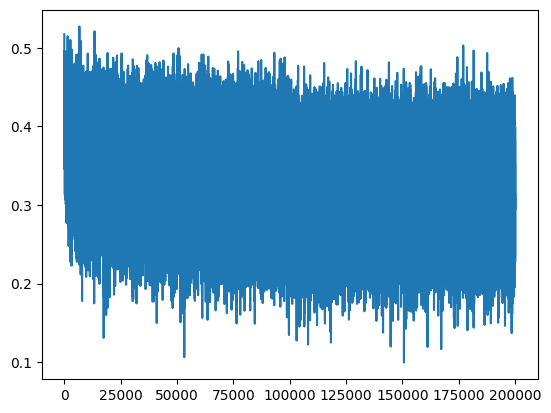

In [15]:
plt.plot(lossi);

Our loss graph is very thick because 32 batch elements are too few so the network can get very lucky or unlucky to get extreme values for loss per batch.

In [11]:
for layer in layers:
  layer.training = False

## Get The Split Loss

In [17]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': {Xtr, Ytr},
    'val': {Xdev, Ydev},
    'test': {Xte, Yte}
  }[split]

  emb = C[x]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')  
split_loss('val')

train 2.066289186477661
val 2.1113224029541016


## Sample From The Network

In [18]:
n_samples = 20

for _ in range(n_samples):
  out = []
  context = [0] * block_size # init context with all dots ...
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
      x = layer(x)  
    logits = x
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))    

lawto.
elah.
ashka.
neston.
jellieah.
katherrandre.
fuegh.
ruleksopiana.
kynzie.
jah.
ney.
kendotcarudidit.
ami.
sidy.
ceaviela.
kashleig.
revela.
das.
pet.
nee.


## Fixing the Learning Rate Plot

In [19]:
lossi[:10]

[0.5173180103302002,
 0.5139991641044617,
 0.5047512650489807,
 0.5043305158615112,
 0.5075897574424744,
 0.5042809247970581,
 0.4836309552192688,
 0.494352787733078,
 0.4959421157836914,
 0.4865306317806244]

In [20]:
torch.tensor(lossi).view(-1, 1000).shape # each row is 1000 consecutive losses

torch.Size([200, 1000])

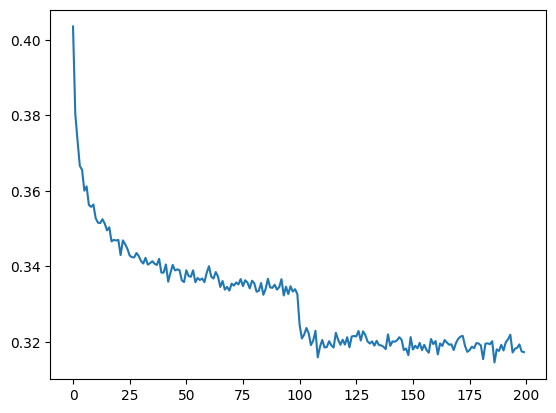

In [21]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)); # plotting the means of 1000 consecutive losses

Plotting average loss per 1000 steps has given us a much better graph in which we can see the loss decreasing as we train the network. We can also observe the learning rate decay at 100k steps which allowed the network to reach a new local minimum.

## Adding Embedding Layer and `emb.view` In The Layers List

In [12]:
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

In [13]:
class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []

In [14]:
n_embed = 10
n_hidden = 200

layers = [
  Embedding(vocab_size, n_embed),
  Flatten(),
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  layers[-1].weight *= 0.1 # make last layer less confident

parameters = [p for layer in layers for p in layer.parameters()] 
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12097


In [15]:
n_iters = 200_000
batch_size = 32
lossi = []

for i in range(n_iters):

  # mini batch const.
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  x = Xb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01 # lr decay
  for p in parameters:
    p.data += -lr * p.grad # lr * grad = update

  # track stats
  if i % 10_000 == 0:
    print(f'{i:7d}/{n_iters:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.3078


## Using Pytorch Containers To Organize Our Layers

The Pytorch `nn.Sequential` module maintains a list of layers and a passes a given input through the layers sequentailly.

In [16]:
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [24]:
n_embed = 10
n_hidden = 200

model = Sequential([
  Embedding(vocab_size, n_embed),
  Flatten(),
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12097


In [25]:
n_iters = 200_000
batch_size = 32
lossi = []

for i in range(n_iters):

  # mini batch const.
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01 # lr decay
  for p in parameters:
    p.data += -lr * p.grad # lr * grad = update

  # track stats
  if i % 10_000 == 0:
    print(f'{i:7d}/{n_iters:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3081
  10000/ 200000: 2.3527
  20000/ 200000: 2.2910
  30000/ 200000: 2.0704
  40000/ 200000: 2.7088
  50000/ 200000: 2.1617
  60000/ 200000: 1.7696
  70000/ 200000: 2.1958
  80000/ 200000: 2.1225
  90000/ 200000: 2.1233
 100000/ 200000: 1.9281
 110000/ 200000: 2.1444
 120000/ 200000: 1.8447
 130000/ 200000: 2.3055
 140000/ 200000: 1.8116
 150000/ 200000: 1.7944
 160000/ 200000: 2.4228
 170000/ 200000: 2.7034
 180000/ 200000: 2.2609
 190000/ 200000: 1.9912


In [26]:
for layer in model.layers:
  layer.training = False

In [27]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': {Xtr, Ytr},
    'val': {Xdev, Ydev},
    'test': {Xte, Yte}
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')  
split_loss('val')

train 2.0659425258636475
val 2.1116952896118164


In [28]:
n_samples = 20

for _ in range(n_samples):
  out = []
  context = [0] * block_size # init context with all dots ...
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))    

aathy.
avrie.
tilani.
talin.
srick.
tyitland.
josida.
zyleegaih.
zett.
gene.
meleen.
jashlyli.
hasalizabella.
ellow.
kana.
lan.
asbinslon.
quarizleigh.
everan.
rosean.


Because the losses are very similar, we are not overfitting too much and we can make more progress by scaling up the size of the network.

## Increasing Our Block Size

Let's increase our context length to take 8 characters instead of 3.

In [29]:
block_size = 8

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [30]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


The main problem with our network is that we are crushing all the characters into a single layer at the beginning. We are crushing a lot of information very quickly. We want this to look more like a wavenet in which all the characters aren't crushed into a single layer, they are crushed slowly by fusing two characters at a time. The wavenet paper calls it a Stack of Dialated Causal Convolutional Layers.

In [31]:
n_embed = 10
n_hidden = 200

model = Sequential([
  Embedding(vocab_size, n_embed),
  Flatten(),
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

22097


Our parameters have increased because our first linear layer takes a larger `fan_in` because of a larger `block_size`.

Let's see what kind of results we get just be increasing the context length.

In [32]:
n_iters = 200_000
batch_size = 32
lossi = []

for i in range(n_iters):

  # mini batch const.
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01 # lr decay
  for p in parameters:
    p.data += -lr * p.grad # lr * grad = update

  # track stats
  if i % 10_000 == 0:
    print(f'{i:7d}/{n_iters:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.6963
  10000/ 200000: 2.3334
  20000/ 200000: 2.3190
  30000/ 200000: 1.8630
  40000/ 200000: 2.1266
  50000/ 200000: 1.7115
  60000/ 200000: 2.6461
  70000/ 200000: 1.6137
  80000/ 200000: 2.1748
  90000/ 200000: 2.1129
 100000/ 200000: 1.8385
 110000/ 200000: 1.9528
 120000/ 200000: 1.8992
 130000/ 200000: 2.0436
 140000/ 200000: 2.3513
 150000/ 200000: 1.9679
 160000/ 200000: 1.9944
 170000/ 200000: 2.6103
 180000/ 200000: 2.0441
 190000/ 200000: 2.0601


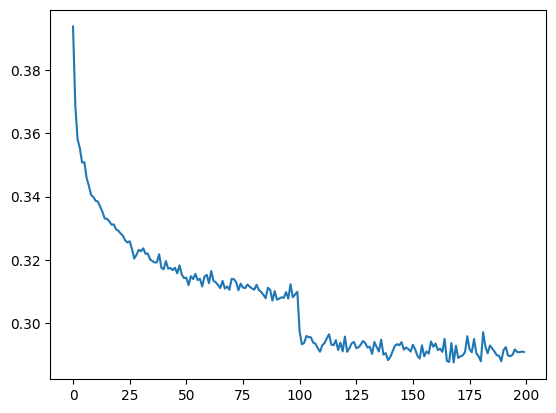

In [37]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [35]:
for layer in model.layers:
  layer.training = False

In [36]:
split_loss('train')  
split_loss('val')

train 1.9259016513824463
val 2.032945156097412


We can see that our loss has improved by increasing the context length. Therefore we can squeeze out more performance for the current baseline network by optimizing the hyper params.

In [38]:
for _ in range(n_samples):
  out = []
  context = [0] * block_size # init context with all dots ...
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))    

fared.
eliesha.
luca.
axztyn.
anana.
seniya.
maller.
grejson.
mela.
kaylena.
demonicio.
bastam.
trisla.
alyjah.
somali.
daryah.
adelyn.
jahlani.
amary.
torria.


## Implementing Wavenet

Let's look at our our tensors as they pass through the network.

In [40]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  4,  1, 14, 14],
        [ 5, 13,  9, 12, 25,  7, 18,  1],
        [ 0,  0,  0,  0, 11,  1,  5, 19],
        [11,  1, 25, 26, 12, 25, 14, 14]])

In [41]:
model.layers[0].out.shape # output of the embedding layer

torch.Size([4, 8, 10])

In [42]:
model.layers[1].out.shape # output of the flatten layer

torch.Size([4, 80])

In [43]:
model.layers[2].out.shape # output of the linear layer

torch.Size([4, 200])

### Matmul Operator In Pytorch Is Powerful

We can even multiply higher dimensional tensors as long as the last dim of tensor 1 and first dim of tensor 2 match. The other dimensions are treated as batch dimensions and matmul is performed in parallel over the last dim.

In [44]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [45]:
(torch.randn(4, 5, 6, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 6, 200])

We can use this to optimize our network.

We have an input of 8 integer tokens `[0, 1, 2, 3, 4, 5, 6, 7]`. We don't want to matmul 80 values (`n_embed * batch_size`) at once. Instead we'll flatten every two consequtive elements and then matmul `[(0, 1), (2, 3), (4, 5), (6, 7)]`. We want to process these 4 groups in parallel so this can be our batch dimension. So we have a batch dimension of 4 in an individual example and also 8 as our overall batch dimension.

So in the first layer we don't want 8 characters and 80 tokens to come in instead we want 2 characters fused as 20 tokens to come in. 

In [46]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

We'll have to modify our Linear layer to take 20 values as `fan_in` and also the flatten layer to flatten 2 tokens instead of all 8 at once.

In [48]:
l = list(range(10))
l

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [49]:
l[::2] # get only even indices

[0, 2, 4, 6, 8]

In [50]:
l[1::2] # get only odd indices

[1, 3, 5, 7, 9]

In [52]:
e = torch.randn(4, 8, 10)
e_even = e[:, ::2, :] # get all batch elems of dim 1 and only even in dim 2 and all from last dim
e_odd = e[:, 1::2, :]

In [56]:
explicit = torch.cat([e_even, e_odd], dim=2)
explicit.shape

torch.Size([4, 4, 20])

We can also do the same by calling `view`.

In [59]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

### Updating `Flatten`

In [61]:
class FlattenConsecutive:
  def __init__(self, n): # n = number of elements to concat in the last dim
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

Let's check if the dimensions work out with the new `FlattenConsecutive` function when we use `block_size`.

In [62]:
n_embed = 10
n_hidden = 200

model = Sequential([
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(block_size),
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

22097


In [63]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 19, 16, 15],
        [ 0,  0,  0,  0,  0,  0,  0, 19],
        [ 0,  0,  0,  0, 14,  1, 11,  1],
        [ 0,  0, 10,  1, 13,  9, 25,  1]])

In [67]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


Things seem correct so now let's flatten only two character tokens at a time and update the linear layer.

In [68]:
n_embed = 10
n_hidden = 200

model = Sequential([
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

170897


This gives a much larger model. Let's inspect the dimensions across the layers.

In [69]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 12,  1, 18, 25,  9],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 19],
        [ 0,  0,  0,  0,  0,  0, 11, 15]])

In [70]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


## Training The New Architecture

To compare the architectures better let's reduce the number of params to bring it close to what we had before.

In [72]:
n_embed = 10
n_hidden = 68

model = Sequential([
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

22397


In [73]:
n_iters = 200_000
batch_size = 32
lossi = []

for i in range(n_iters):

  # mini batch const.
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01 # lr decay
  for p in parameters:
    p.data += -lr * p.grad # lr * grad = update

  # track stats
  if i % 10_000 == 0:
    print(f'{i:7d}/{n_iters:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.4873
  10000/ 200000: 2.3808
  20000/ 200000: 2.2836
  30000/ 200000: 1.8675
  40000/ 200000: 2.4153
  50000/ 200000: 1.9188
  60000/ 200000: 1.8894
  70000/ 200000: 1.8569
  80000/ 200000: 1.9307
  90000/ 200000: 1.7127
 100000/ 200000: 2.2545
 110000/ 200000: 2.4853
 120000/ 200000: 2.0190
 130000/ 200000: 1.8557
 140000/ 200000: 2.3227
 150000/ 200000: 2.0529
 160000/ 200000: 2.0687
 170000/ 200000: 1.7865
 180000/ 200000: 2.1428
 190000/ 200000: 1.9987


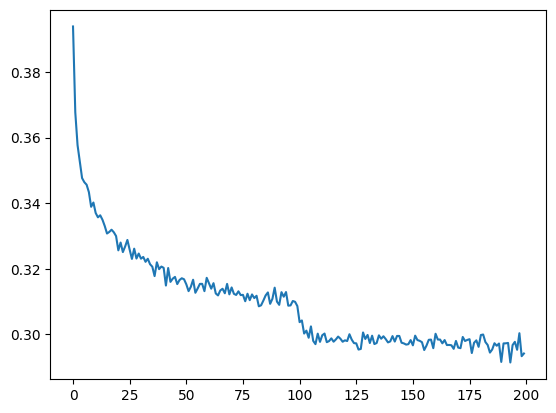

In [74]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [75]:
for layer in model.layers:
  layer.training = False

In [76]:
split_loss('train')  
split_loss('val')

train 1.9504756927490234
val 2.03218412399292


We get identical performance with our wavenet but there is room for more optimization.

## Updating Batch Norm

Earlier, our batch norm function assumed that x is 2D but now it's getting a 3 dimensional input. We're not getting an error because of broadcasting but our batch norm isn't working properly.

In [77]:
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True) # 1, 4, 68
evar = e.var(0, keepdim=True) # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [79]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

Instead of 68 means and variances we have a tensor of `[4, 68]`. So our batch norm is currently working in parallel over 4*68 values instead of just 68 values. Instead, we want 4 to be a batch dimension so we don't want to average over 32 numbers, we want to average over 32 * 4 for every single one of the 68 values.

In [80]:
e = torch.randn(32, 4, 68)
emean = e.mean((0, 1), keepdim=True) # 1, 1, 68
evar = e.var((0, 1), keepdim=True) # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [81]:
emean.shape

torch.Size([1, 1, 68])

In [82]:
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # params trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers trained with running momentum update
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # forward pass
    if self.training:
        if x.ndim == 2:
          dim = 0
        elif x.ndim == 3:
          dim = (0, 1)  
        xmean = x.mean(dim, keepdim=True) # batch mean
        xvar = x.var(dim, keepdim=True, unbiased=True) # batch var
    else:
        xmean = self.running_mean
        xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # eps is added in denom to prevent div with 0 
    self.out = self.gamma * xhat + self.beta

    #update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]        

## Training With Updated Batch Norm

In [83]:
n_embed = 10
n_hidden = 68

model = Sequential([
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

22397


In [84]:
n_iters = 200_000
batch_size = 32
lossi = []

for i in range(n_iters):

  # mini batch const.
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01 # lr decay
  for p in parameters:
    p.data += -lr * p.grad # lr * grad = update

  # track stats
  if i % 10_000 == 0:
    print(f'{i:7d}/{n_iters:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.6877
  10000/ 200000: 1.9637
  20000/ 200000: 1.9134
  30000/ 200000: 1.9761
  40000/ 200000: 2.3525
  50000/ 200000: 1.8316
  60000/ 200000: 1.9208
  70000/ 200000: 2.0999
  80000/ 200000: 1.7129
  90000/ 200000: 2.0235
 100000/ 200000: 1.8867
 110000/ 200000: 2.0567
 120000/ 200000: 2.0484
 130000/ 200000: 2.2375
 140000/ 200000: 2.0918
 150000/ 200000: 1.7330
 160000/ 200000: 1.6537
 170000/ 200000: 2.0234
 180000/ 200000: 2.0963
 190000/ 200000: 2.0762


In [85]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [86]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

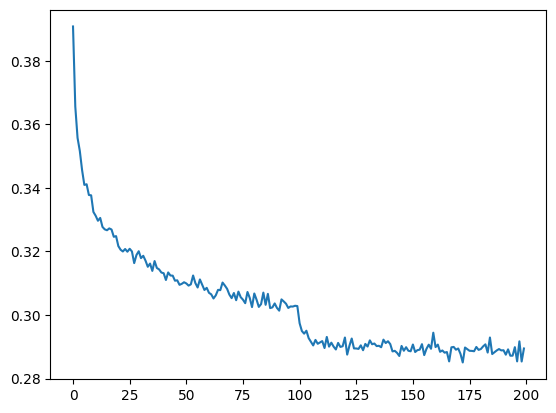

In [87]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [88]:
for layer in model.layers:
  layer.training = False

In [89]:
split_loss('train')  
split_loss('val')

train 1.9247967004776
val 2.0259811878204346


We get a tiny improvement on our losses.